In [1]:
from math import ceil
from joblib import Memory
from datetime import timedelta
import pickle
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mmocc.config import (
    fig_column_width,
    fig_page_width,
    golden_ratio,
    silver_ratio,
    bronze_ratio,
    default_image_backbone,
    default_sat_backbone,
    figures_path,
    image_feature_dims,
    sat_feature_dims,
    cache_path,
)
from mmocc.plot_utils import setup_matplotlib
from mmocc.train_utils import img_model_labels, sat_model_labels
from mmocc.utils import (
    get_focal_species_ids,
    powerset,
    experiment_to_filename,
    get_scientific_taxon_map,
)

setup_matplotlib()

# disable jax pre-allocation
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

figures_dir = str(figures_path)
os.makedirs(figures_dir, exist_ok=True)
use_nonlinear_regressors = False

memory = Memory(cache_path / "joblib_figures")
memory.reduce_size(age_limit=timedelta(days=30))


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df


In [2]:
image_backbones = [default_image_backbone, "visdiff_clip", "expert_clip"]
sat_backbones = [default_sat_backbone, "graft_visdiff", "graft_expert"]

modalities = ["image", "sat", "covariates"]
modalities_subsets = [set(modalities)]

COMBOS = {
    "full": (default_image_backbone, default_sat_backbone),
    "clip_visdiff": ("visdiff_clip", default_sat_backbone),
    "clip_expert": ("expert_clip", default_sat_backbone),
    "graft_visdiff": (default_image_backbone, "graft_visdiff"),
    "graft_expert": (default_image_backbone, "graft_expert"),
}


def get_experiment_paths(enable_cache_busting=True):
    experiment_paths = []
    for taxon_id in get_focal_species_ids():
        for modalities_subset in modalities_subsets:
            for _, (image_backbone, sat_backbone) in COMBOS.items():
                filename = experiment_to_filename(
                    taxon_id,
                    modalities_subset,
                    image_backbone,
                    sat_backbone,
                    "pkl",
                )
                filepath = cache_path / "fit_results" / filename
                if not filepath.exists():
                    print(f"Skipping missing experiment {filename}")
                    continue

                if enable_cache_busting:
                    with open(filepath, "rb") as f:
                        hash = hashlib.md5(f.read()).hexdigest()
                else:
                    hash = None
                experiment_paths.append((filepath, hash))

    return experiment_paths


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df


enable_cache_busting = True
df = load_df(get_experiment_paths(enable_cache_busting))
# df = pd.read_pickle(cache_path / "figure_data_refit_graft.pkl")
df_raw = df.copy()

df.to_pickle(cache_path / "figure_data_refit_graft.pkl")

df["lppd_test_norm"] = (df["lppd_test"] - df["lppd_null_test"]) / (
    df["lppd_oracle_test"] - df["lppd_null_test"]
)

df


Skipping missing experiment 00804e75-09ef-44e5-8984-85e365377d47_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 07843615-e1fc-49d8-9821-fd1d7ff2e773_modalities_covariates_image_sat_image_expert_clip_sat_alphaearth.pkl
Skipping missing experiment 07843615-e1fc-49d8-9821-fd1d7ff2e773_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 0f2e2c41-f1bb-4cdd-8e97-ba7cffba3e86_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 16ec4010-f175-4de7-8a99-85aadec3963b_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 1db1c6e2-2ea9-45a6-ab69-a730133298eb_modalities_covariates_image_sat_image_expert_clip_sat_alphaearth.pkl
Skipping missing experiment 1db1c6e2-2ea9-45a6-ab69-a730133298eb_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 41930eb4-2283-

  0%|          | 0/94 [00:00<?, ?it/s]

_______________________________________________________load_df - 651.4s, 10.9min


,taxon_id,scientific_name,common_name,modalities,image_backbone,sat_backbone,limit_to_range,modalities_scaler,modalities_pca,mean_naive_occupancy_train,...,biolith_roc_auc_oracle_test,biolith_errors,best_params,clip_descriptor_texts,clip_descriptor_scores,sat_backbone_data,descriptor_source,graft_descriptor_texts,graft_descriptor_scores,lppd_test_norm
0,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,0.999684,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,NaN,NaN,1.154555
1,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",visdiff_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...","[open grassy field, wide sky view, open grassl...","[1.0, 1.0, 1.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,4.034284
2,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",expert_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",[Herbaceous (Subcanopy herbaceous vegetation g...,"[3.0, 2.0, 2.0, 2.0, 1.0]",NaN,NaN,NaN,NaN,4.037280
3,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,graft,visdiff,"[open grassy field, wide sky view, open grassl...","[1.0, 1.0, 1.0, 1.0, 1.0]",1.072739
4,07843615-e1fc-49d8-9821-fd1d7ff2e773,Dasypus novemcinctus,nine-banded armadillo,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.220657,...,1.000000,[],"{'prior_type': 'normal', 'occ_params': {'loc':...",NaN,NaN,NaN,NaN,NaN,NaN,0.128027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,febff896-db40-4ac8-bcfe-5bb99a600950,Odocoileus hemionus,mule deer,"[covariates, image, sat]",expert_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.171047,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",[Shrubs (Woody plants of smaller stature than ...,"[3.0, 3.0, 2.0, 2.0, 2.0]",NaN,NaN,NaN,NaN,-0.580034
90,febff896-db40-4ac8-bcfe-5bb99a600950,Odocoileus hemionus,mule deer,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.171047,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,graft,visdiff,"[bare deciduous trees, a dirt road through tre...","[0.9911999702453613, 0.9796000123023987, 0.969...",-0.483278
91,ffe603fc-4920-4302-96d0-65f708bd5b2d,Urocyon cinereoargenteus,grey fox,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.061603,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,NaN,NaN,0.051381
92,ffe603fc-4920-4302-96d0-65f708bd5b2d,Urocyon cinereoargenteus,grey fox,"[covariates, image, sat]",visdiff_clip,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.061603,...,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...","[leaf-littered ground, rocky ground, rocky cre...","[1.0, 1.0, 1.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,-0.00790

In [3]:
min_occupancy = 0.1  # TODO
low_occupancy_mask = df["mean_naive_occupancy_test"] < min_occupancy
print(
    f"Removing {df[low_occupancy_mask]['taxon_id'].nunique()} species with low occupancy (< 0.1)"
)
df = df[df["mean_naive_occupancy_test"] >= min_occupancy]


Removing 10 species with low occupancy (< 0.1)


### Compare GRAFT refits against the full model and CLIP refits

Benchmark GRAFT descriptor refits (sat backbone) against the full model and standard
CLIP descriptor refits (image backbone).


In [4]:
comparison_metrics = [
    "lppd_test_norm",
    "biolith_ap_test",
    "biolith_roc_auc_test",
    "lr_map_test",
    "lr_mcc_test",
]


def align_combo(image_backbone: str, sat_backbone: str) -> pd.DataFrame:
    mask = (df["image_backbone"] == image_backbone) & (df["sat_backbone"] == sat_backbone)
    return df[mask].set_index("taxon_id")[
        ["scientific_name", *comparison_metrics]
    ]


baseline_df = align_combo(*COMBOS["full"])
clip_visdiff_df = align_combo(*COMBOS["clip_visdiff"])
clip_expert_df = align_combo(*COMBOS["clip_expert"])
graft_visdiff_df = align_combo(*COMBOS["graft_visdiff"])
graft_expert_df = align_combo(*COMBOS["graft_expert"])


def summarize_against_reference(target: pd.DataFrame, reference: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = reference.index.intersection(target.index)
    merged = (
        reference.loc[overlap, comparison_metrics]
        .add_suffix("_ref")
        .join(target.loc[overlap, comparison_metrics].add_suffix(f"_{label}"))
    )
    rows = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_ref"]
        rows.append(
            {
                "metric": metric,
                "n_species": len(deltas),
                "mean_delta": deltas.mean(),
                "median_delta": deltas.median(),
                "improved_%": 100 * (deltas > 0).mean(),
            }
        )
    return pd.DataFrame(rows)


baseline_comparisons = {
    "clip_visdiff": summarize_against_reference(clip_visdiff_df, baseline_df, "clip_visdiff"),
    "clip_expert": summarize_against_reference(clip_expert_df, baseline_df, "clip_expert"),
    "graft_visdiff": summarize_against_reference(graft_visdiff_df, baseline_df, "graft_visdiff"),
    "graft_expert": summarize_against_reference(graft_expert_df, baseline_df, "graft_expert"),
}

baseline_summary = (
    pd.concat(
        [
            df.assign(model=label)
            for label, df in baseline_comparisons.items()
        ],
        ignore_index=True,
    )
    .sort_values(["metric", "model"])
)

# Compare graft refits directly against the corresponding CLIP refits.
comparison_pairs = {
    "graft_vs_clip_visdiff": (graft_visdiff_df, clip_visdiff_df),
    "graft_vs_clip_expert": (graft_expert_df, clip_expert_df),
}

pairwise_summary = (
    pd.concat(
        [
            summarize_against_reference(target, reference, label).assign(model=label)
            for label, (target, reference) in comparison_pairs.items()
        ],
        ignore_index=True,
    )
    .sort_values(["metric", "model"])
)

baseline_summary.round(3), pairwise_summary.round(3)


(                  metric  n_species  mean_delta  median_delta  improved_%  \
 6        biolith_ap_test          8      -0.069        -0.066       0.000   
 1        biolith_ap_test         17      -0.035        -0.030      11.765   
 16       biolith_ap_test          0         NaN           NaN         NaN   
 11       biolith_ap_test         17      -0.022        -0.014      29.412   
 7   biolith_roc_auc_test          8      -0.067        -0.050       0.000   
 2   biolith_roc_auc_test         17      -0.027        -0.023      11.765   
 17  biolith_roc_auc_test          0         NaN           NaN         NaN   
 12  biolith_roc_auc_test         17      -0.027        -0.019       5.882   
 5         lppd_test_norm          8      -0.193        -0.126       0.000   
 0         lppd_test_norm         17      -0.090        -0.070      29.412   
 15        lppd_test_norm          0         NaN           NaN         NaN   
 10        lppd_test_norm         17      -0.073        -0.035  

/tmp/ipykernel_2841424/1439893331.py:71: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(             model         scientific_name  delta  reference  target
 96     clip_expert           Canis latrans -0.033      0.506   0.473
 99     clip_expert           Sciurus niger -0.035      0.482   0.448
 97     clip_expert           Vulpes vulpes -0.037      0.391   0.353
 98     clip_expert              Lynx rufus -0.043      0.350   0.307
 94     clip_expert    Sciurus carolinensis -0.088      0.857   0.768
 21    clip_visdiff           Pecari tajacu  0.081      0.325   0.406
 20    clip_visdiff        Ursus americanus  0.024      0.361   0.385
 17    clip_visdiff    Dasypus novemcinctus -0.003      0.440   0.437
 26    clip_visdiff     Meleagris gallopavo -0.007      0.304   0.296
 22    clip_visdiff  Odocoileus virginianus -0.008      0.941   0.933
 146  graft_visdiff           Pecari tajacu  0.015      0.325   0.340
 153  graft_visdiff           Vulpes vulpes  0.007      0.391   0.398
 155  graft_visdiff              Lynx rufus  0.006      0.350   0.355
 143  graft_visdiff 

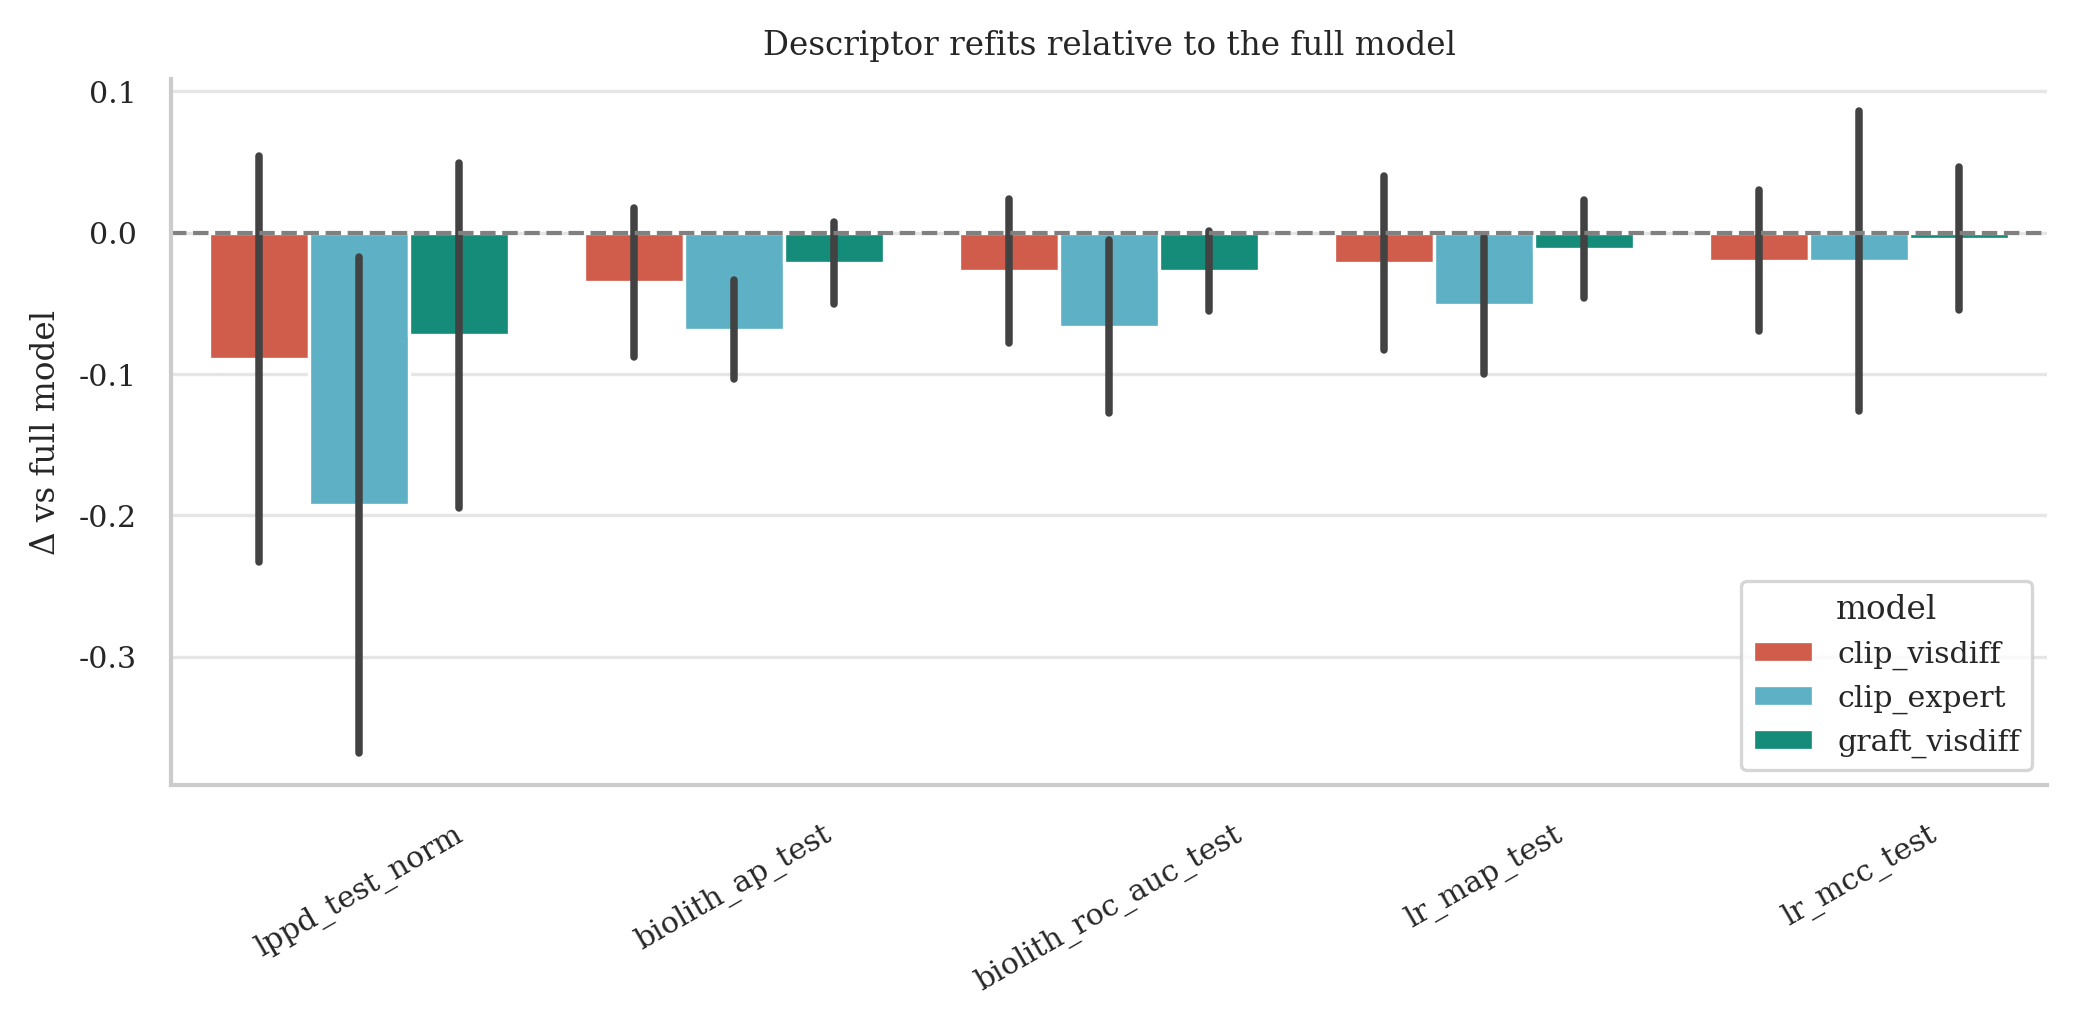

In [5]:
def build_delta_table(target: pd.DataFrame, reference: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = reference.index.intersection(target.index)
    merged = (
        reference.loc[overlap, ["scientific_name", *comparison_metrics]]
        .rename_axis("taxon_id")
        .join(
            target.loc[overlap, comparison_metrics],
            lsuffix="_reference",
            rsuffix=f"_{label}",
        )
    )
    records = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_reference"]
        for taxon_id, delta in deltas.items():
            records.append(
                {
                    "taxon_id": taxon_id,
                    "scientific_name": merged.loc[taxon_id, "scientific_name"],
                    "metric": metric,
                    "model": label,
                    "delta": delta,
                    "reference": merged.loc[taxon_id, f"{metric}_reference"],
                    "target": merged.loc[taxon_id, f"{metric}_{label}"],
                }
            )
    return pd.DataFrame(records)


baseline_deltas = pd.concat(
    [
        build_delta_table(clip_visdiff_df, baseline_df, "clip_visdiff"),
        build_delta_table(clip_expert_df, baseline_df, "clip_expert"),
        build_delta_table(graft_visdiff_df, baseline_df, "graft_visdiff"),
        build_delta_table(graft_expert_df, baseline_df, "graft_expert"),
    ],
    ignore_index=True,
)

pairwise_deltas = pd.concat(
    [
        build_delta_table(graft_visdiff_df, clip_visdiff_df, "graft_vs_clip_visdiff"),
        build_delta_table(graft_expert_df, clip_expert_df, "graft_vs_clip_expert"),
    ],
    ignore_index=True,
)

subset = baseline_deltas[baseline_deltas["metric"] == "biolith_ap_test"]
top_improvements = (
    subset.sort_values(["model", "delta"], ascending=[True, False])
    .groupby("model")
    .head(5)
    .loc[:, ["model", "scientific_name", "delta", "reference", "target"]]
)

fig, ax = plt.subplots(figsize=(7, 3.5))
sns.barplot(
    data=baseline_deltas,
    x="metric",
    y="delta",
    hue="model",
    estimator=np.mean,
    errorbar="sd",
    ax=ax,
)
ax.axhline(0, color="gray", linewidth=1, linestyle="--")
ax.set_ylabel("Δ vs full model")
ax.set_xlabel("")
ax.set_title("Descriptor refits relative to the full model")
ax.tick_params(axis="x", rotation=30)
fig.tight_layout()

top_improvements.round(3), pairwise_deltas


ValueError: zero-size array to reduction operation fmin which has no identity

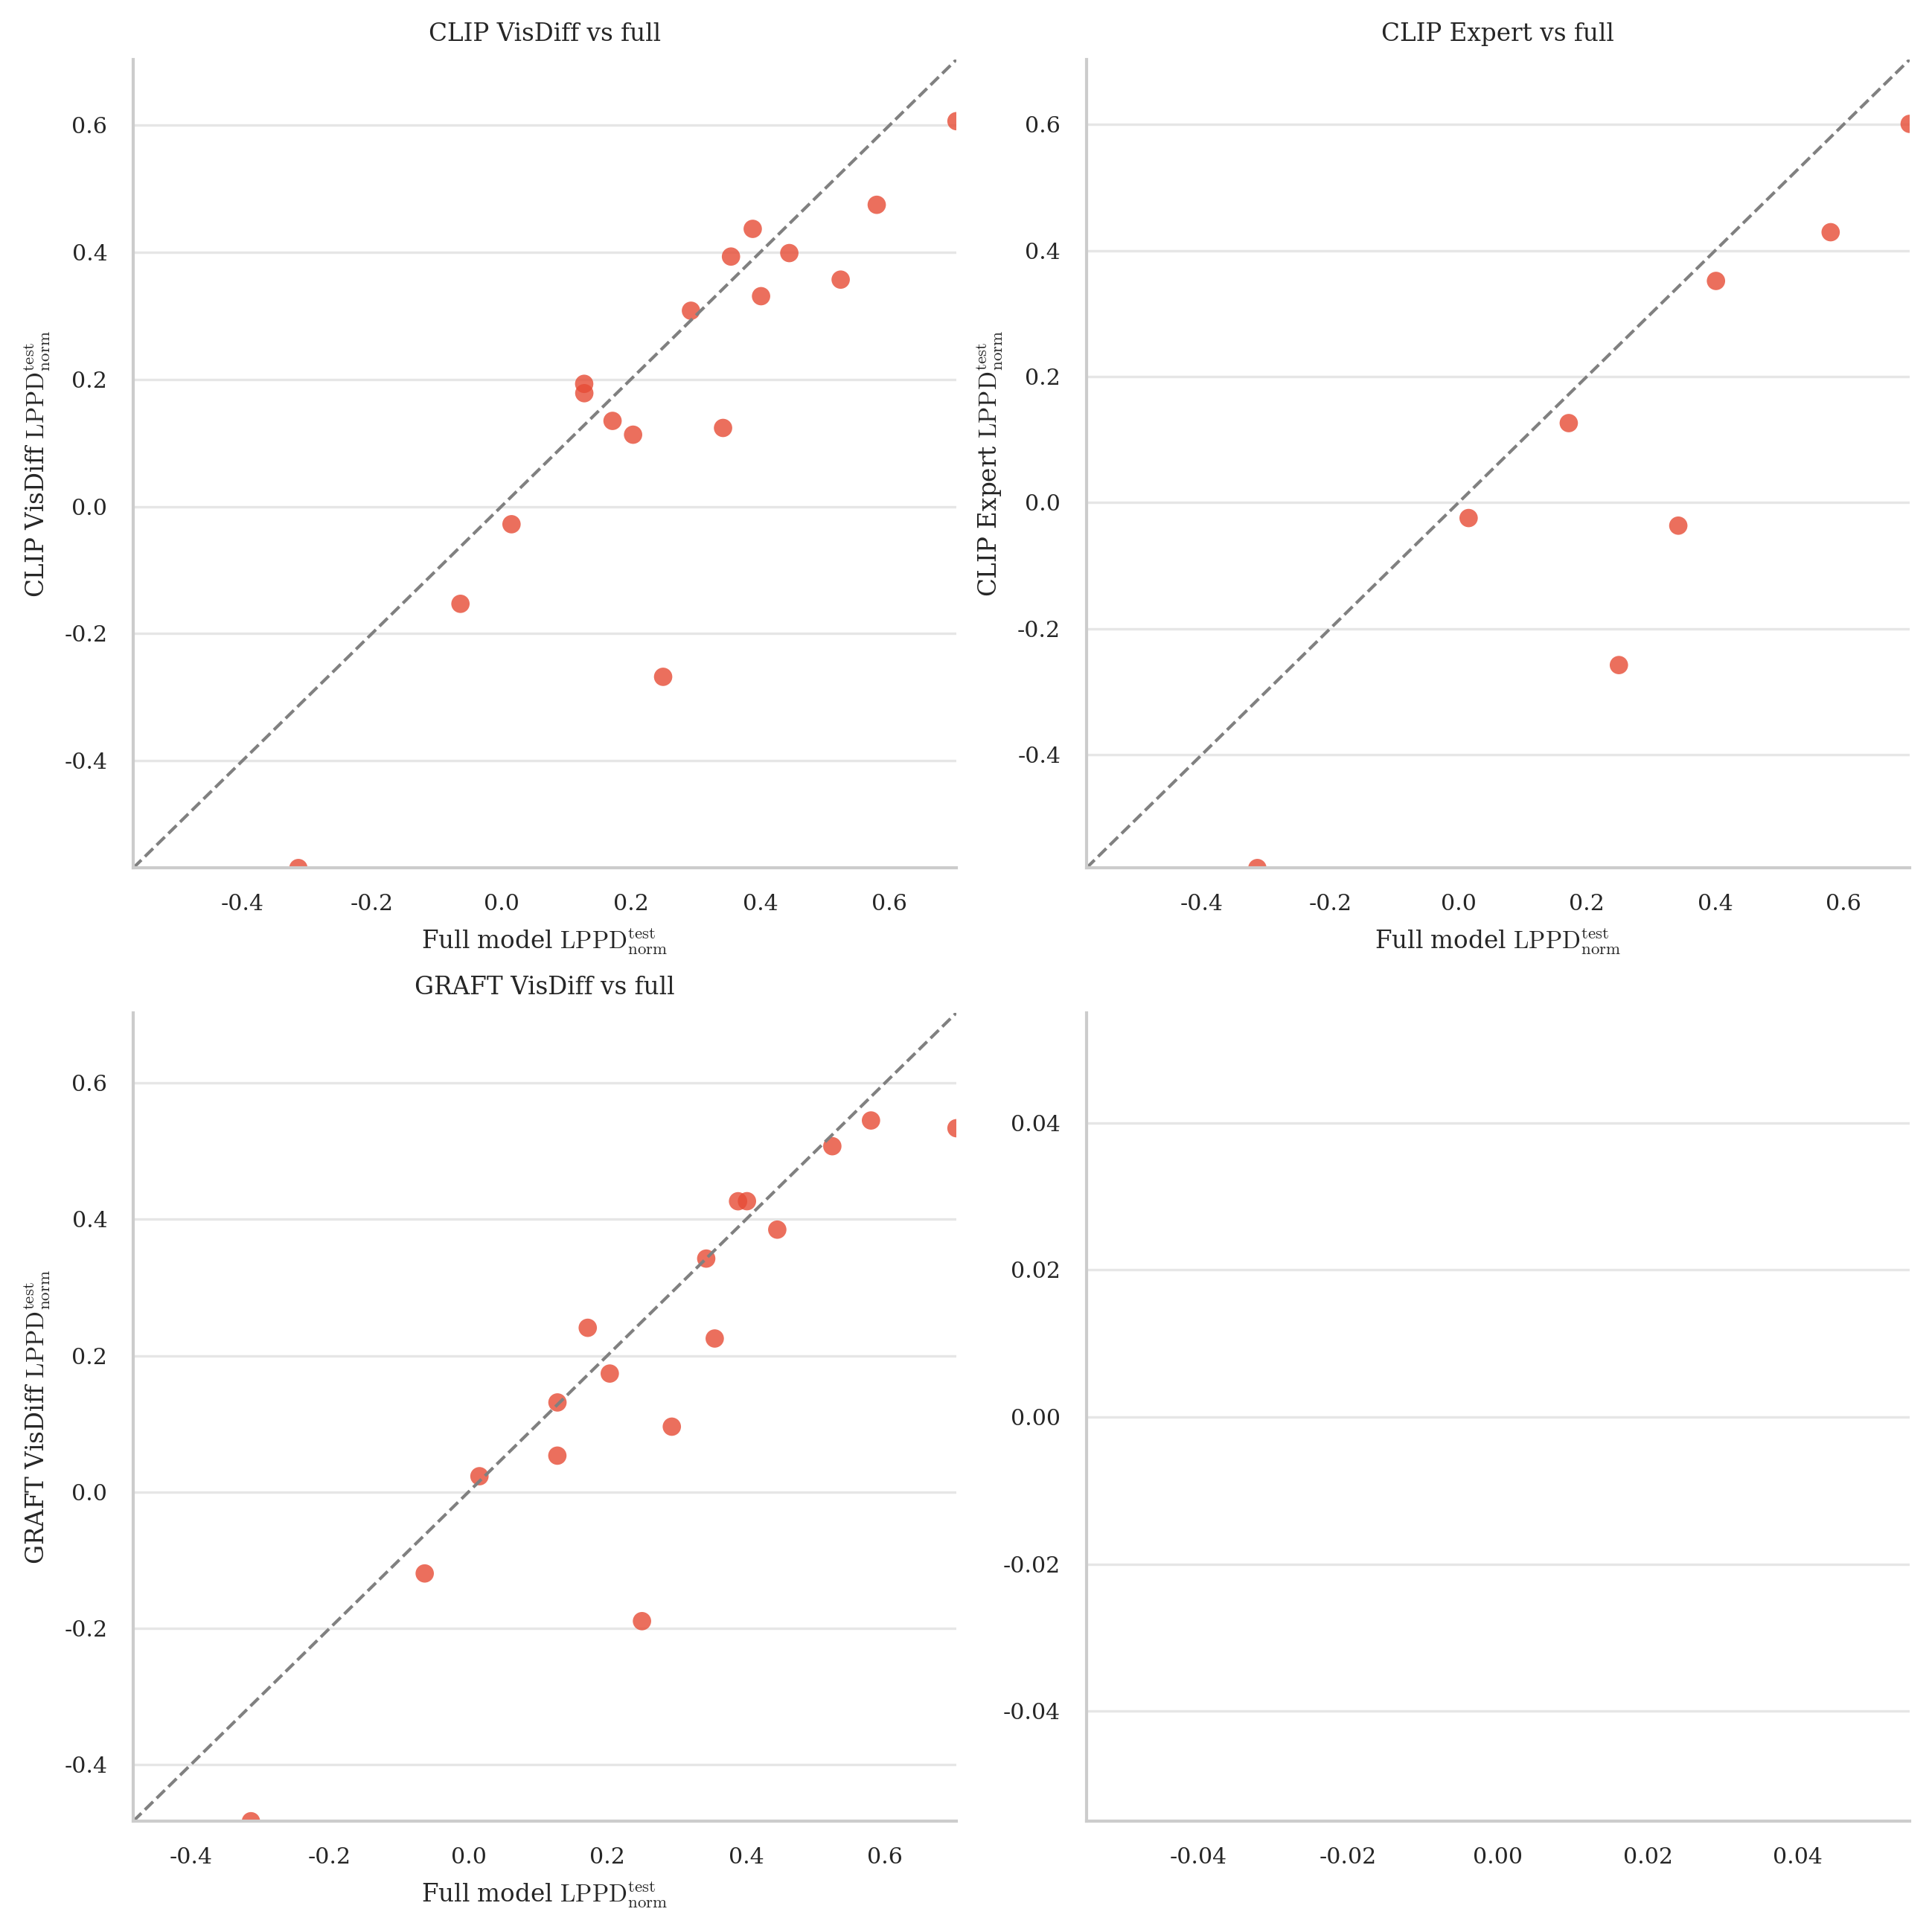

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(fig_page_width, fig_page_width))

plot_specs = [
    ("CLIP VisDiff vs full", clip_visdiff_df, "CLIP VisDiff"),
    ("CLIP Expert vs full", clip_expert_df, "CLIP Expert"),
    ("GRAFT VisDiff vs full", graft_visdiff_df, "GRAFT VisDiff"),
    ("GRAFT Expert vs full", graft_expert_df, "GRAFT Expert"),
]

for ax, (title, target_df, label) in zip(axes.flatten(), plot_specs):
    overlap = baseline_df.index.intersection(target_df.index)
    scatter_data = (
        baseline_df.loc[overlap, ["scientific_name", "lppd_test_norm"]]
        .rename(columns={"lppd_test_norm": "baseline"})
        .join(
            target_df.loc[overlap, ["lppd_test_norm"]].rename(
                columns={"lppd_test_norm": "target"}
            )
        )
    )

    ax.scatter(
        scatter_data["baseline"],
        scatter_data["target"],
        s=35,
        alpha=0.8,
        edgecolor="none",
    )

    lims = [
        np.nanmin(scatter_data[["baseline", "target"]].values),
        np.nanmax(scatter_data[["baseline", "target"]].values),
    ]
    ax.plot(lims, lims, linestyle="--", color="gray", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(title)
    ax.set_xlabel(r"Full model $\text{LPPD}_\text{norm}^\text{test}$")
    ax.set_ylabel(label + r" $\text{LPPD}_\text{norm}^\text{test}$")

fig.tight_layout()
fig.savefig(
    f"{figures_dir}/refit_graft_lppd_comparison.pdf", bbox_inches="tight", transparent=True
)


In [ ]:
df.iloc[df["lppd_test_norm"].argmin()].to_dict()


{'taxon_id': 'febff896-db40-4ac8-bcfe-5bb99a600950',
 'scientific_name': 'Odocoileus hemionus',
 'common_name': 'mule deer',
 'modalities': ['covariates', 'image', 'sat'],
 'image_backbone': 'expert_clip',
 'sat_backbone': 'alphaearth',
 'limit_to_range': True,
 'modalities_scaler': {'covariates': StandardScaler(),
  'image': StandardScaler(),
  'sat': StandardScaler()},
 'modalities_pca': {'covariates': PCA(n_components=26),
  'image': PCA(n_components=5),
  'sat': PCA(n_components=64)},
 'mean_naive_occupancy_train': 0.17104714226115977,
 'mean_naive_occupancy_test': 0.2707948243992606,
 'naive_detection_prob_train': 0.7152495537699985,
 'naive_detection_prob_test': 0.46767153244266274,
 'mean_num_observations_train': 0.17375565610859728,
 'mean_num_observations_test': 0.13896699718810124,
 'mean_num_nonnan_train': 8840,
 'mean_num_nonnan_test': 6757,
 'test_sites_too_close': 1858,
 'lr_mcc_test': -0.32232617712834816,
 'lr_precision_test': 0.0990990990990991,
 'lr_recall_test': 0.15